# PAA

In [1]:
!pip3 install finance-datareader==0.9.42
!pip3 install pandas-datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.6 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd


def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        # rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        if(netCumReturn.iloc[-1].sum() ==0):
            totalAsset =1
        else:
            totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 

In [4]:
def avgMomentumScoretable(data, n=12, name="Close"):
  result = pd.DataFrame(data)

  if len(result.columns) ==1 :  
    result.columns = [name+"_m"]
    for i in range(len(data)-1,-1,-1):
      tmp =0
      if i>(n-1):
        for j in range(i-1,i-n-1, -1):
          if data[i]>data[j] : tmp = tmp+1
      result[name+"_m"][i] = tmp
  else : 
    name_list = result.columns
    for i in range(0, len(name_list)):
      result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
      result = result.drop([name_list[i]], axis=1)
    result.columns = name_list

  return  result[n:]

In [5]:
def weightScore(data):
  weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
  # weight['cash'] = np.where(weight.sum(axis=1) == 0,1,0)
  return weight

In [140]:
start = "2010"
end = "2022-10-31"

In [141]:
SPY = getCloseDataPandas("SPY",start, end) #1
QQQ = getCloseDataPandas("QQQ",start, end) #2
IWM = getCloseDataPandas("IWM",start, end) #3
VGK = getCloseDataPandas("VGK",start, end) #4
EWJ = getCloseDataPandas("EWJ",start, end) #5
EEM = getCloseDataPandas("EEM",start, end) #6
VNQ = getCloseDataPandas("VNQ",start, end) #7
GLD = getCloseDataPandas("GLD",start, end) #8
DBC = getCloseDataPandas("DBC",start, end) #9
HYG = getCloseDataPandas("HYG",start, end) #10
LQD = getCloseDataPandas("LQD",start, end) #11
TLT = getCloseDataPandas("TLT",start, end) #12
IEF = getCloseDataPandas("IEF",start, end)  # IEF

closeDataSet = pd.concat([SPY, QQQ,IWM,VGK, EWJ, EEM, VNQ, GLD, DBC, HYG, LQD, TLT, IEF], axis=1)
closeDataSet.columns = ["SPY", "QQQ","IWM","VGK", "EWJ", "EEM", "VNQ", "GLD", "DBC", "HYG", "LQD", "TLT","IEF"]
closeDataSet.dropna(inplace=True)
closeDataSet

,SPY,QQQ,IWM,VGK,EWJ,EEM,VNQ,GLD,DBC,HYG,LQD,TLT,IEF
Date,,,,,,,,,,,,,
2010-01-04,113.330002,46.419998,63.980000,49.959999,39.959999,42.709999,44.549999,109.800003,25.240000,88.529999,104.699997,89.809998,88.820000
2010-01-05,113.629997,46.419998,63.759998,49.880001,40.200001,43.020000,44.500000,109.699997,25.270000,88.949997,105.199997,90.389999,89.209999
2010-01-06,113.709999,46.139999,63.700001,50.180000,40.360001,43.110001,44.419998,111.510002,25.719999,89.180000,104.889999,89.180000,88.849998
2010-01-07,114.190002,46.169998,64.169998,49.860001,40.000000,42.860001,44.900002,110.820000,25.400000,89.540001,105.019997,89.330002,88.849998
2010-01-08,114.570000,46.549999,64.519997,50.360001,40.480000,43.200001,44.570000,111.370003,25.379999,89.680000,105.250000,89.290001,88.959999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,384.920013,284.209991,178.169998,49.990002,50.090000,34.209999,81.209999,154.000000,25.090000,73.239998,100.760002,95.089996,94.180000
2022-10-26,382.019989,277.929993,179.050003,50.529999,50.380001,34.770000,81.160004,154.979996,25.559999,73.440002,101.220001,96.459999,94.660004
2022-10-27,379.980011,272.869995,179.089996,50.099998,49.750000,34.500000,81.279999,154.740005,25.600000,73.980003,101.690002,97.470001,95.330002


In [142]:
rebalDate = getRebalancingDate(closeDataSet) #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data

In [143]:
name_list = ["SPY", "QQQ","IWM","VGK", "EWJ", "EEM", "VNQ", "GLD", "DBC", "HYG", "LQD", "TLT"]

weight = priceOnRebalDate.copy()
weight = weight.drop(['IEF'], axis=1)
final_weight = pd.DataFrame( index = priceOnRebalDate.index, columns=priceOnRebalDate.columns)

for i in name_list:
  sum =0
  for j in range(0,12):
    sum += priceOnRebalDate[i].shift(j+1)
  weight['mthavg_'+i] = sum/12


In [144]:
for i in name_list:
  weight[i]= np.where(weight[i]<weight["mthavg_"+i], 1,0)
weight['count'] = weight.loc[:,:"TLT"].sum(axis =1)


for i in range(0, len(final_weight)):
  w =0
  count = weight['count'][i]
  if count ==1 : w=0.1667
  elif count ==2 : w=0.3333
  elif count ==3: w=0.5
  elif count ==4: w=0.6667
  elif count ==5: w=.8333
  elif count >=6 : w=1

  final_weight['IEF'][i] =w

In [145]:
for i in name_list:
  final_weight[i] = (priceOnRebalDate[i]/weight["mthavg_"+i] )-1

In [146]:
final_weight

,SPY,QQQ,IWM,VGK,EWJ,EEM,VNQ,GLD,DBC,HYG,LQD,TLT,IEF
Date,,,,,,,,,,,,,
2010-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2010-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2010-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2010-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2010-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,-0.145873,-0.222993,-0.201085,-0.189888,-0.184974,-0.175872,-0.139382,-0.012756,0.191058,-0.133771,-0.141676,-0.181857,1
2022-07-29,-0.058190,-0.110223,-0.095352,-0.133404,-0.117057,-0.157021,-0.057307,-0.039635,0.136082,-0.066667,-0.091580,-0.148729,1
2022-08-31,-0.092031,-0.146031,-0.101239,-0.184231,-0.145034,-0.150826,-0.108801,-0.065294,0.092918,-0.101733,-0.121488,-0.172929,1


In [147]:
rank = final_weight.loc[:,:"TLT"].rank(axis=1, ascending=False)

In [148]:
for i in name_list:
  final_weight[i] = np.where(rank[i] <7 , (1-final_weight['IEF'])/6 ,0)

In [149]:
_, CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet,weightDf=final_weight)
cagr, dd, mdd = getEvaluation(CumReturn)

최종 수익률: 2.7409848226156233
cagr: 1.0823215631544985
mdd: 19.35697398728988


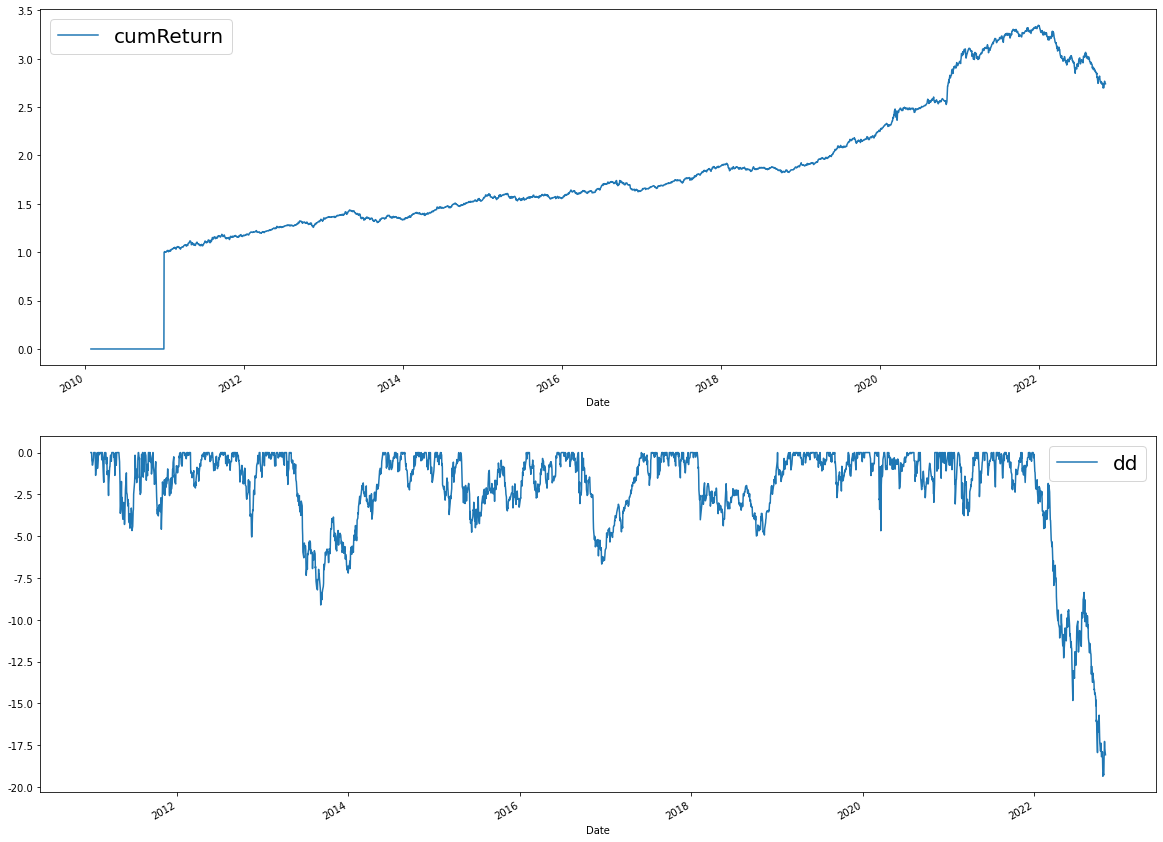

In [150]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
CumReturn.plot(label="cumReturn")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd).plot(label="dd")
plt.legend(fontsize=20)

plt.show()